# LSTM Model — Emission Point Classification

This notebook develops a Long Short-Term Memory (LSTM) model for classifying the emission point of particles (E1, E2, E3) in a simulated industrial environment, based on sequential sensor readings. Unlike the MLP or CNN, the LSTM is designed to capture temporal dependencies in the data, making it especially suitable for time series forecasting and event detection.

---

## 🧠 Objectives

- Build a deep learning model using LSTM layers to handle time-dependent input sequences;
- Train the model on sensor windows generated from multiple simulation tags;
- Apply proper scientific methodology to evaluate model performance, ensuring no data leakage between simulations;
- Measure the model’s ability to generalize to unseen simulation conditions (10% holdout set);
- Compare results with previous models (MLP and CNN) to guide future refinements.

---

## 📁 Data Structure and Considerations

- **Input Data**: `complete_dataset.csv` — rows correspond to sensor readings with associated metadata.
- **Sequence Generation**: Time windows (e.g., 30 time steps per sample) are created for each simulation (`tag`) independently.
- **Normalization**: StandardScaler is applied **after** the data split to prevent leakage.
- **Target Variable**: The emission class — `E1`, `E2`, or `E3`.

---

## ✅ Notebook Structure

1. Load Processed Data and Remove Constant Sensors  
2. Generate LSTM-compatible Input Sequences  
3. Perform Group-Based Train/Validation Split (by simulation `tag`)  
4. Normalize Sensor Inputs  
5. Define and Compile LSTM Model  
6. Train Model with Callbacks and Class Weights  
7. Evaluate on Validation Set  
8. Final Generalization Test on 10% Unseen Data  
9. Plot Metrics and Analyze Bias/Variance  
10. Draw Scientific Conclusions

---

> ⚠️ All experiments follow good scientific practices, including group-wise validation to prevent overfitting on simulation-specific patterns, and final testing on unseen simulation tags for proper generalization assessment.


### 0. Import Libraries and Configure GPU (if available)

We begin by importing all the essential libraries for data processing, modeling, evaluation, and visualization. Additionally, we configure TensorFlow to use the GPU, which significantly accelerates training for deep learning models like LSTM.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Progress bar
from tqdm.keras import TqdmCallback
from tqdm import tqdm

# GPU config
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU detected and configured:", gpus[0])
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU detected. Using CPU instead.")

✅ GPU detected and configured: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 1. Load Processed Dataset and Remove Constant Sensors

In this step, we load the preprocessed sensor dataset and remove the constant sensors identified during the exploratory analysis. These sensors provide no variation and could negatively impact the learning process. We also separate a generalization subset (10% of the data) that will be evaluated only at the end to assess the true generalization capacity of the model on unseen simulations.


In [4]:
import pandas as pd

# Load complete dataset
df = pd.read_csv('../data/processed/dataset_timeseries.csv')

# Load list of constant sensors and remove them
with open('../data/processed/sensor_constantes.txt', 'r') as f:
    constant_sensors = [line.strip() for line in f.readlines()]

df = df.drop(columns=constant_sensors, errors='ignore')

# Separate 10% of the dataset for final generalization testing (unseen simulations)
df_full = df.copy()
df_gen = df_full.sample(frac=0.10, random_state=42)
df_modeling = df_full.drop(df_gen.index).reset_index(drop=True)

### 2. Generate Time-Based Input Sequences for LSTM

LSTM models require input sequences with a fixed number of time steps. In this step, we generate sliding windows of sensor readings for each simulation (`tag`) independently. Each window corresponds to a temporal segment of the simulation and is labeled according to the emission class (`E1`, `E2`, `E3`).

We use a window size of 30 time steps and a step size of 5 to generate overlapping windows. The function below ensures that data from different simulations is not mixed, preserving the integrity of each sequence.


In [7]:
def create_lstm_windows(df, window_size=30, step=5):
    """
    Generate LSTM windows from the dataset.
    Each window is a sequence of `window_size` time steps from the same simulation (tag).

    Returns:
        - X_seq: np.array of shape (n_windows, window_size, n_features)
        - y_seq: np.array of corresponding labels
        - tags: list of simulation tags (used for group-aware splitting)
    """
    sequences = []
    labels = []
    groups = []

    for tag in df['tag'].unique():
        group_data = df[df['tag'] == tag].sort_values('Time')
        X = group_data.drop(columns=['classe', 'Altura', 'Time'], errors='ignore')
        y = group_data['classe'].iloc[0]  # one label per simulation
        n = len(X)

        for i in range(0, n - window_size + 1, step):
            window = X.iloc[i:i + window_size].values
            if window.shape[0] == window_size:
                sequences.append(window)
                labels.append(y)
                groups.append(tag)

    return np.array(sequences), np.array(labels), np.array(groups)

### 3. Apply Sequence Generation and Encode Target Labels

We now generate the sequential input data using the modeling dataset (`df_modeling`) and encode the categorical labels (`classe`) into numerical format. This prepares the data for training an LSTM model.

The generated structure will be:
- `X_seq`: input sequences of shape (n_windows, window_size, n_features)
- `y_encoded`: encoded class labels (E1, E2, E3 → 0, 1, 2)
- `tags`: simulation identifiers for group-aware validation


In [8]:
# Generate input sequences
X_seq, y_seq, tags = create_lstm_windows(df_modeling, window_size=30, step=5)

# Encode target classes numerically
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_seq)

# Check result shapes
print("✅ Sequence shape:", X_seq.shape)
print("✅ Labels shape:", y_encoded.shape)
print("✅ Unique classes:", encoder.classes_)

KeyError: 'tag'

### 4. Perform Group-Based Train/Validation Split

To prevent data leakage and ensure reliable evaluation, we split the dataset into training and validation sets based on simulation tags (`tag`). This guarantees that the model is tested on simulations it has never seen before.

We use `GroupShuffleSplit` to randomly assign 70% of the simulations to training and 30% to validation.


In [23]:
from sklearn.model_selection import GroupShuffleSplit

# Create splitter
splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Apply split based on tags (simulations)
for train_idx, val_idx in splitter.split(X_seq, y_encoded, groups=tags):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

print("✅ Training set:", X_train.shape, "labels:", y_train.shape)
print("✅ Validation set:", X_val.shape, "labels:", y_val.shape)

✅ Training set: (9786, 30, 322) labels: (9786,)
✅ Validation set: (4368, 30, 322) labels: (4368,)


### 5. Normalize Input Sequences

We normalize the sensor data using `StandardScaler`, fitting it only on the training set to avoid data leakage. The input sequences are reshaped before and after normalization to match the expected LSTM input format: `(samples, time_steps, features)`.

This step ensures that all features contribute equally during training.


In [24]:
from sklearn.preprocessing import StandardScaler

# Extract sequence dimensions
n_t, n_f = X_train.shape[1], X_train.shape[2]

# Flatten for scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_f)).reshape(-1, n_t, n_f)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_f)).reshape(-1, n_t, n_f)

# Cast to float32 for TensorFlow
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)

print("✅ Normalization complete")


✅ Normalization complete


### 6. Define and Compile the LSTM Model

We build a sequential LSTM model designed to learn temporal patterns from the sensor readings. The architecture includes two LSTM layers, dropout regularization, and batch normalization to improve generalization.

The final layer is a dense softmax unit that outputs class probabilities for the three emission sources (E1, E2, E3).

We compile the model using the Adam optimizer and sparse categorical cross-entropy loss, suitable for integer-labeled classification tasks.


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization

# Define architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_t, n_f)),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(64),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            99072     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

### 7. Train the LSTM Model with Progress Bar and Print Validation Metrics

The model is trained with real-time progress feedback using `TqdmCallback`. After training, we evaluate the model’s classification performance on the validation set using multiple scientific metrics: accuracy, F1-score, precision, recall, and Cohen’s kappa.

These metrics help assess both the general performance and the model’s ability to treat all classes fairly.



In [13]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm.keras import TqdmCallback

# Compute class weights for imbalance correction
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    TqdmCallback(verbose=1)
]

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=0  # tqdm handles this
)

# Evaluate
y_pred_val = model.predict(X_val_scaled).argmax(axis=1)

print("\n📊 Evaluation on Validation Set:")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_val):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_pred_val, average='macro'):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val, average='macro', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_val, average='macro'):.4f}")
print(f"Kappa:     {cohen_kappa_score(y_val, y_pred_val):.4f}")



0epoch [00:00, ?epoch/s]
  0%|                                                                                        | 0/30 [00:00<?, ?epoch/s]
  0%|                                                                                    | 0.00/904 [00:00<?, ?batch/s]
  0%|                                                | 1.00/904 [00:11<2:51:14, 11.4s/batch, loss=1.93, accuracy=0.125]
  1%|▎                                                   | 5.00/904 [00:11<25:45, 1.72s/batch, loss=1.24, accuracy=0.1]
  1%|▌                                                 | 10.0/904 [00:11<10:22, 1.44batch/s, loss=1.08, accuracy=0.112]
  2%|▉                                                 | 17.0/904 [00:11<04:47, 3.09batch/s, loss=1.06, accuracy=0.153]
  3%|█▍                                                | 26.0/904 [00:11<02:27, 5.97batch/s, loss=1.01, accuracy=0.204]
  4%|█▉                                               | 35.0/904 [00:11<01:29, 9.74batch/s, loss=0.944, accuracy=0.238]
  5%|██▍       


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


 13%|█       | 4/30 [01:03<06:18, 14.57s/epoch, loss=0.105, accuracy=0.93, val_loss=1.36, val_accuracy=0.797, lr=0.001]
  0%|                                                         | 0.00/904 [00:00<?, ?batch/s, loss=0.105, accuracy=0.93]
  1%|▍                                               | 9.00/904 [00:00<00:11, 80.5batch/s, loss=0.0929, accuracy=0.934]
  2%|▉                                                | 18.0/904 [00:00<00:10, 83.7batch/s, loss=0.096, accuracy=0.931]
  3%|█▍                                              | 28.0/904 [00:00<00:10, 87.1batch/s, loss=0.0848, accuracy=0.931]
  4%|██                                                 | 37.0/904 [00:00<00:10, 84.1batch/s, loss=0.1, accuracy=0.938]
  5%|██▌                                              | 47.0/904 [00:00<00:09, 86.1batch/s, loss=0.091, accuracy=0.939]
  6%|███                                              | 56.0/904 [00:00<00:09, 86.4batch/s, loss=0.0874, accuracy=0.94]
  7%|███▍                               

404/404 [==============================] - 8s 6ms/step

📊 Evaluation on Validation Set:
Accuracy:  0.7864
F1-Score:  0.4367
Precision: 0.4279
Recall:    0.4524
Kappa:     0.2050


### 8. Final Evaluation on the Generalization Set (10% Unseen Data)

In this step, we test the model’s ability to generalize by evaluating it on a 10% holdout set that was never used during training or validation.

This assessment reflects the model’s real-world robustness when facing unseen simulations and emission patterns. The same preprocessing and label encoding are applied to the generalization data.


In [15]:
# Prepare generalization set
X_gen = df_gen.drop(columns=['classe', 'tag', 'Altura', 'Time'], errors='ignore')
y_gen = df_gen['classe']

# Apply label encoding to targets
y_gen_encoded = encoder.transform(y_gen)

# Generate sequences from the generalization set
X_gen_seq, y_gen_seq, _ = create_lstm_windows(df_gen, window_size=30, step=5)
y_gen_encoded_seq = encoder.transform(y_gen_seq)

# Normalize using the same scaler (fit only on train)
n_t, n_f = X_gen_seq.shape[1], X_gen_seq.shape[2]
X_gen_scaled = scaler.transform(X_gen_seq.reshape(-1, n_f)).reshape(-1, n_t, n_f).astype(np.float32)

# Predict
y_gen_pred = model.predict(X_gen_scaled).argmax(axis=1)

# Evaluate
print("\n📈 Generalization Set Evaluation (10% unseen data):")
print(f"Accuracy:  {accuracy_score(y_gen_encoded_seq, y_gen_pred):.4f}")
print(f"F1-Score:  {f1_score(y_gen_encoded_seq, y_gen_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_gen_encoded_seq, y_gen_pred, average='macro', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_gen_encoded_seq, y_gen_pred, average='macro'):.4f}")
print(f"Kappa:     {cohen_kappa_score(y_gen_encoded_seq, y_gen_pred):.4f}")


134/134 [==============================] - 1s 6ms/step

📈 Generalization Set Evaluation (10% unseen data):
Accuracy:  0.2353
F1-Score:  0.1851
Precision: 0.2034
Recall:    0.2555
Kappa:     -0.1097


In [30]:
# Verificar se cada tag tem uma única classe
df_check = df.groupby("tag")["classe"].nunique()
print(df_check.value_counts())


classe
1    81
Name: count, dtype: int64


In [31]:
print(df["classe"].value_counts())

classe
E1    81077
Name: count, dtype: int64


Shape: (22952, 9901)

Sample:


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f9891,f9892,f9893,f9894,f9895,f9896,f9897,f9898,f9899,classe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1



Missing values:
f0       0
f6603    0
f6596    0
f6597    0
f6598    0
dtype: int64

Class distribution:
classe
E1    7938
E2    7938
E3    7076
Name: count, dtype: int64


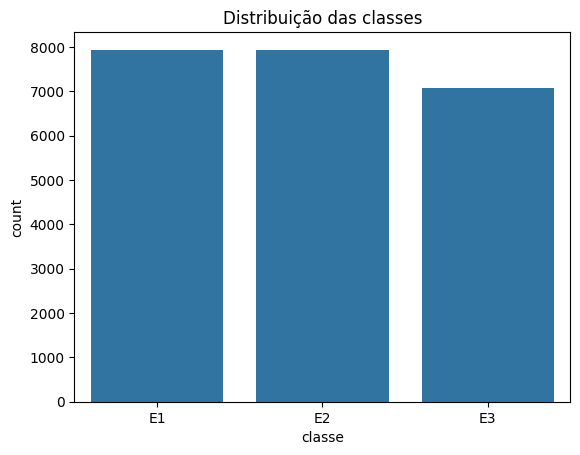

,count,mean,std,min,25%,50%,75%,max
f0,22952.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
f1,22952.0,0.000259,0.277011,-0.378917,0.0,0.0,0.0,3.174019
f2,22952.0,-0.000618,0.149740,-0.370363,0.0,0.0,0.0,4.878439
f3,22952.0,-0.000264,0.362990,-0.378669,0.0,0.0,0.0,5.468614
f4,22952.0,-0.000453,0.160716,-0.377884,0.0,0.0,0.0,6.541545
f5,22952.0,0.000291,0.216727,-0.378913,0.0,0.0,0.0,4.036876
f6,22952.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
f7,22952.0,0.000186,0.372791,-0.404915,0.0,0.0,0.0,5.048461
f8,22952.0,0.000008,0.110787,-0.401333,0.0,0.0,0.0,2.986943
f9,22952.0,0.000113,0.277125,-0.378879,0.0,0.0,0.0,3.859483


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando o dataset
df = pd.read_csv("../data/processed/dataset_timeseries.csv")

# 1. Verificar formato geral
print("Shape:", df.shape)
print("\nSample:")
display(df.head())

# 2. Verificar se há valores nulos
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head())

# 3. Verificar distribuição das classes
print("\nClass distribution:")
print(df["classe"].value_counts())

sns.countplot(data=df, x="classe")
plt.title("Distribuição das classes")
plt.show()

# 4. Verificar variabilidade de algumas features
sensor_sample = df.columns[:10]
df[sensor_sample].describe().T

In [2]:
# Remove coluna de classe temporariamente para análise numérica
features_only = df.drop(columns=["classe"])

# 1. Quantas colunas têm pelo menos um valor diferente de zero
non_zero_cols = (features_only != 0).any(axis=0).sum()
print(f"Columns with at least one non-zero value: {non_zero_cols} / {features_only.shape[1]}")

# 2. Quantas linhas têm pelo menos um valor diferente de zero
non_zero_rows = (features_only != 0).any(axis=1).sum()
print(f"Rows with at least one non-zero value: {non_zero_rows} / {features_only.shape[0]}")


Columns with at least one non-zero value: 6810 / 9900
Rows with at least one non-zero value: 19489 / 22952
